## Plot survival prediction results

In this notebook, we'll generate box plots and heatmaps for the survival prediction results.

The files analyzed in this notebook are generated by the `run_survival_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff for pairwise comparisons (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# significance cutoff, after FDR correction
SIG_ALPHA = 0.05

# if True, save figures to images directory
SAVE_FIGS = True

In [3]:
# set results directory
me_results_dir = Path(cfg.repo_root,
                      '06_predict_survival',
                      'results_extended_alphas',
                      'results_1000_pca').resolve()
me_results_desc = 'top 1000 PCs'

# set images directory
images_dir = Path(cfg.images_dirs['survival'])

# load results into a single dataframe
me_results_df = su.load_survival_results(me_results_dir)
me_results_df.rename(columns={'identifier': 'cancer_type',
                              'fold_no': 'fold'}, inplace=True)
me_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.85360,train,LIHC,me_450k,shuffled,42,0
1,0.85360,cv,LIHC,me_450k,shuffled,42,0
2,0.41490,test,LIHC,me_450k,shuffled,42,0
3,0.77704,train,LIHC,me_450k,shuffled,42,1
4,0.77704,cv,LIHC,me_450k,shuffled,42,1


### Check model convergence results

In the past we were having issues with model convergence for some cancer types. Let's see how frequently (if at all) this is happening.

In [4]:
me_count_df = (me_results_df[me_results_df.data_type == 'test']
    .groupby(['cancer_type', 'training_data'])
    .count()
)
problem_df = me_count_df[me_count_df['cindex'] != 16].copy()
print(len(problem_df), '/', len(me_count_df))
problem_df

17 / 99


cindex  data_type  signal  seed  fold
cancer_type training_data                                       
CHOL        expression         12         12      12    12    12
            me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
DLBC        expression          4          4       4     4     4
            me_27k              4          4       4     4     4
            me_450k             4          4       4     4     4
ESCA        me_450k            12         12      12    12    12
KICH        expression          8          8       8     8     8
            me_27k              8          8       8     8     8
            me_450k             8          8       8     8     8
KIRC        expression         12         12      12    12    12
PCPG        me_27k             12         12      12    12    12
READ        expression         12         12      12    12    12
            me_27k             12         12      12    12    12
TGCT        me_27k             12         12      12    12    12
THYM        me_27k             12         12      12    12    12
UCS         me_450k            12         12      12    12    12

We'll just drop these missing cancer types from our comparisons for now, although we could debug the issues with model convergence sometime in the future (e.g. by using an extended parameter range).

In [5]:
drop_cancer_types = problem_df.index.get_level_values(0).unique().values
print(drop_cancer_types)

['CHOL' 'DLBC' 'ESCA' 'KICH' 'KIRC' 'PCPG' 'READ' 'TGCT' 'THYM' 'UCS']


### Plot survival prediction results

We want to compare survival prediction for:
* true labels vs. shuffled labels
* between omics types
    
As a metric, for now we're just using the [censored concordance index](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.metrics.concordance_index_censored.html). Essentially, this compares the actual order of events (i.e. death or tumor progression) in the test dataset vs. the order of events predicted by the model in the test samples. A higher concordance index = better prediction.

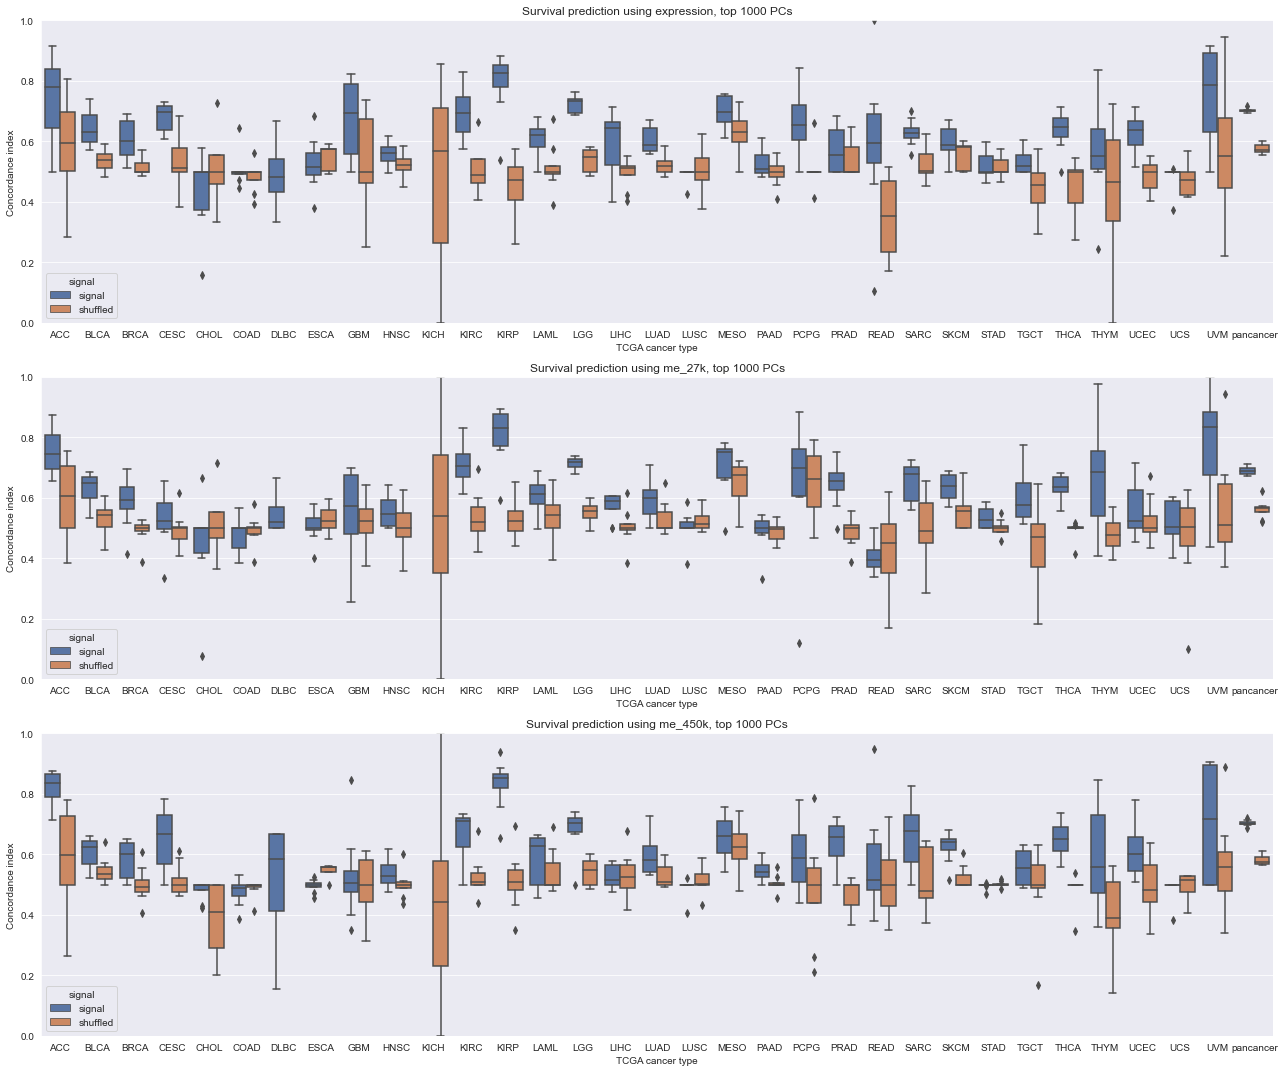

In [6]:
sns.set({'figure.figsize': (18, 15)})
fig, axarr = plt.subplots(3, 1)

for ix, data_type in enumerate(
    me_results_df.training_data.sort_values().unique()
):
    
    ax = axarr[ix]
    
    filtered_df = me_results_df[
        (me_results_df.training_data == data_type) &
        (me_results_df.data_type == 'test')
    ].copy()

    filtered_df.sort_values(by='cancer_type', inplace=True)

    sns.boxplot(data=filtered_df, x='cancer_type', y='cindex', hue='signal',
                hue_order=['signal', 'shuffled'], ax=ax)
    ax.set_xlabel('TCGA cancer type')
    ax.set_ylabel('Concordance index')
    ax.set_title('Survival prediction using {}, {}'.format(data_type,
                                                           me_results_desc))
    ax.set_ylim(0.0, 1.0)
    
plt.tight_layout()

In [7]:
me_results_df['identifier'] = (me_results_df.cancer_type + '_' +
                               me_results_df.training_data)
me_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold,identifier
0,0.85360,train,LIHC,me_450k,shuffled,42,0,LIHC_me_450k
1,0.85360,cv,LIHC,me_450k,shuffled,42,0,LIHC_me_450k
2,0.41490,test,LIHC,me_450k,shuffled,42,0,LIHC_me_450k
3,0.77704,train,LIHC,me_450k,shuffled,42,1,LIHC_me_450k
4,0.77704,cv,LIHC,me_450k,shuffled,42,1,LIHC_me_450k


In [8]:
me_compare_df = au.compare_control_ind(me_results_df,
                                       identifier='identifier',
                                       metric='cindex',
                                       verbose=True)
me_compare_df['cancer_type'] = me_compare_df.identifier.str.split('_', 1, expand=True)[0]
me_compare_df['training_data'] = me_compare_df.identifier.str.split('_', 1, expand=True)[1]

print(len(me_compare_df))
me_compare_df.head()

shapes unequal for CHOL_expression, skipping
shapes unequal for CHOL_me_27k, skipping
shapes unequal for CHOL_me_450k, skipping
shapes unequal for DLBC_expression, skipping
shapes unequal for DLBC_me_27k, skipping
shapes unequal for DLBC_me_450k, skipping
shapes unequal for ESCA_me_450k, skipping
shapes unequal for KICH_expression, skipping
shapes unequal for KICH_me_27k, skipping
shapes unequal for KICH_me_450k, skipping
shapes unequal for KIRC_expression, skipping
shapes unequal for PCPG_me_27k, skipping
shapes unequal for READ_expression, skipping
shapes unequal for READ_me_27k, skipping
shapes unequal for TGCT_me_27k, skipping


656


shapes unequal for THYM_me_27k, skipping
shapes unequal for UCS_me_450k, skipping


,identifier,seed,fold,delta_cindex,cancer_type,training_data
0,ACC_expression,42,0,0.13083,ACC,expression
1,ACC_expression,42,1,0.01374,ACC,expression
2,ACC_expression,42,2,0.16357,ACC,expression
3,ACC_expression,42,3,0.21429,ACC,expression
4,ACC_expression,1,0,0.40689,ACC,expression


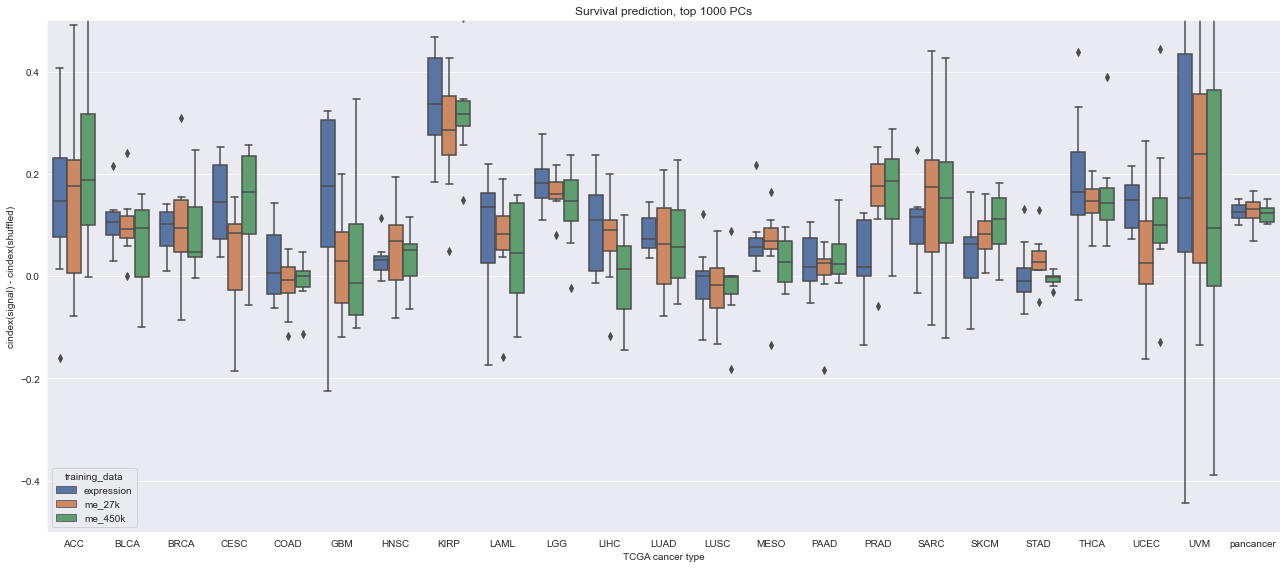

In [9]:
sns.set({'figure.figsize': (18, 8)})
    
me_compare_df.sort_values(by='cancer_type', inplace=True)

sns.boxplot(data=me_compare_df[~me_compare_df.cancer_type.isin(drop_cancer_types)],
            x='cancer_type',
            y='delta_cindex',
            hue='training_data',
            hue_order=sorted(me_compare_df.training_data.unique()))
plt.xlabel('TCGA cancer type')
plt.ylabel('cindex(signal) - cindex(shuffled)')
plt.title('Survival prediction, {}'.format(me_results_desc))
plt.ylim(-0.5, 0.5)
    
plt.tight_layout()

### Heatmap

This is similar to the heatmaps we plotted in the results script in `02_classify_mutations` for the mutation prediction problem. We want to compare data types for predicting survival in different cancer types.

In [10]:
me_all_results_df = au.compare_all_data_types(me_results_df[~me_results_df.cancer_type.isin(drop_cancer_types)],
                                           SIG_ALPHA,
                                           identifier='cancer_type',
                                           metric='cindex')

me_all_results_df.rename(columns={'gene': 'cancer_type'}, inplace=True)
me_all_results_df.sort_values(by='p_value').head(10)

,cancer_type,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
22,pancancer,0.126086,1.686903e-07,0.000004,True,expression,5.411182
22,pancancer,0.122310,2.328269e-07,0.000005,True,me_450k,5.271239
22,pancancer,0.126764,5.911070e-06,0.000136,True,me_27k,3.866606
9,LGG,0.163346,1.307595e-05,0.000150,True,me_27k,3.822829
7,KIRP,0.338455,3.042728e-05,0.000247,True,expression,3.607390
9,LGG,0.184826,3.221092e-05,0.000247,True,expression,3.607390
7,KIRP,0.317063,4.081702e-05,0.000469,True,me_450k,3.328461
19,THCA,0.144070,4.215479e-05,0.000323,True,me_27k,3.490546
20,UCEC,0.141510,9.941860e-05,0.000572,True,expression,3.242865
7,KIRP,0.276697,3.435204e-04,0.001975,True,me_27k,2.704380


In [11]:
me_heatmap_df = (me_all_results_df
    .pivot(index='training_data', columns='cancer_type', values='delta_mean')
    .reindex(sorted(me_compare_df.training_data.unique()))
)
me_heatmap_df.iloc[:, :5]

cancer_type,ACC,BLCA,BRCA,CESC,COAD
training_data,,,,,
expression,0.142953,0.106474,0.090917,0.143731,0.023441
me_27k,0.154597,0.101129,0.096082,0.034561,-0.017983
me_450k,0.226380,0.060913,0.083885,0.139319,-0.010818


In [12]:
raw_results_df = (me_results_df
    .drop(columns=['identifier'])
    .rename(columns={'cancer_type': 'identifier'})
)
raw_results_df.head()

,cindex,data_type,identifier,training_data,signal,seed,fold
0,0.85360,train,LIHC,me_450k,shuffled,42,0
1,0.85360,cv,LIHC,me_450k,shuffled,42,0
2,0.41490,test,LIHC,me_450k,shuffled,42,0
3,0.77704,train,LIHC,me_450k,shuffled,42,1
4,0.77704,cv,LIHC,me_450k,shuffled,42,1


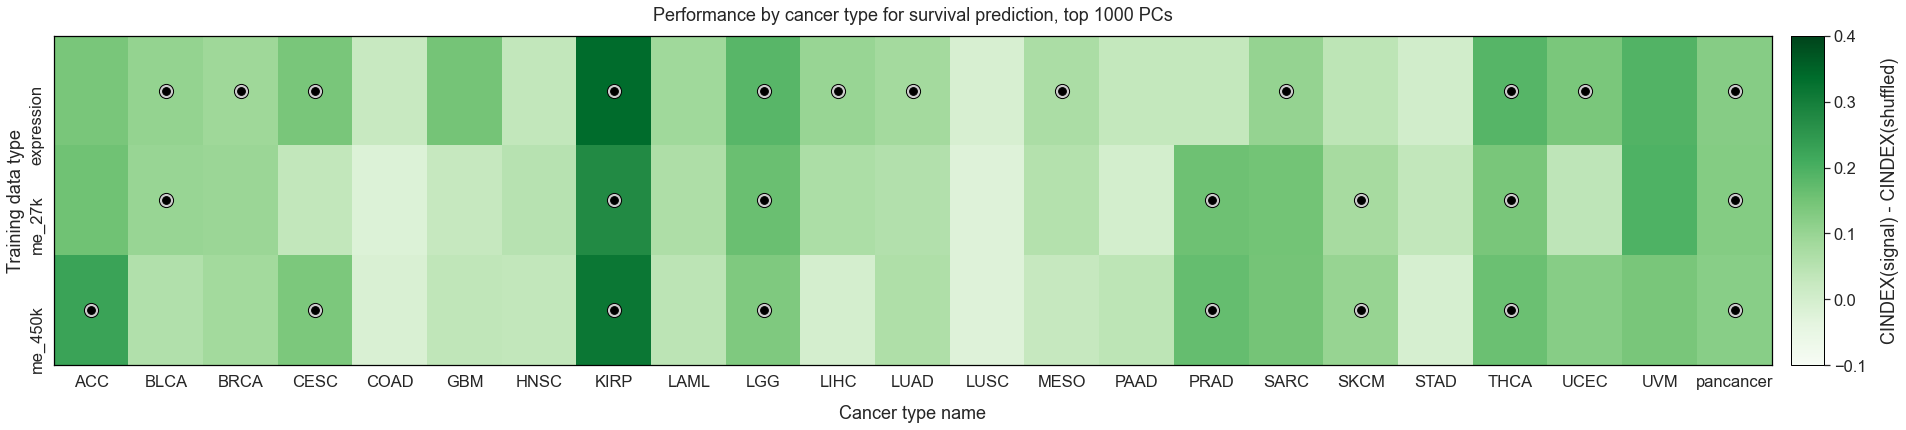

In [13]:
sns.set({'figure.figsize': (28, 6)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(me_heatmap_df,
                      me_all_results_df.reset_index(drop=True),
                      raw_results_df,
                      metric='cindex',
                      id_name='cancer_type',
                      scale=(-0.1, 0.4),
                      origin_eps_x=0.01,
                      origin_eps_y=0.01,
                      length_x=0.965,
                      length_y=0.975)

plt.title('Performance by cancer type for survival prediction, {}'.format(me_results_desc), pad=15)
if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'survival_me_heatmap.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'survival_me_heatmap.png',
                dpi=300, bbox_inches='tight')

Key to above heatmap:

* A grey dot = significantly better than label-permuted baseline, but significantly worse than best-performing data type
* A grey dot with black dot inside = significantly better than label-permuted baseline, and not significantly different from best-performing data type (i.e. "statistically equivalent to best")
* No dot = not significantly better than label-permuted baseline

So we can see that many of the same cancer types are well-predicted using all data types (KIRP, LGG, pancancer), and the predictors based on different datasets tend to be statistically equivalent in many of those cases.

expression: 12/23
me_27k: 7/23
me_450k: 8/23


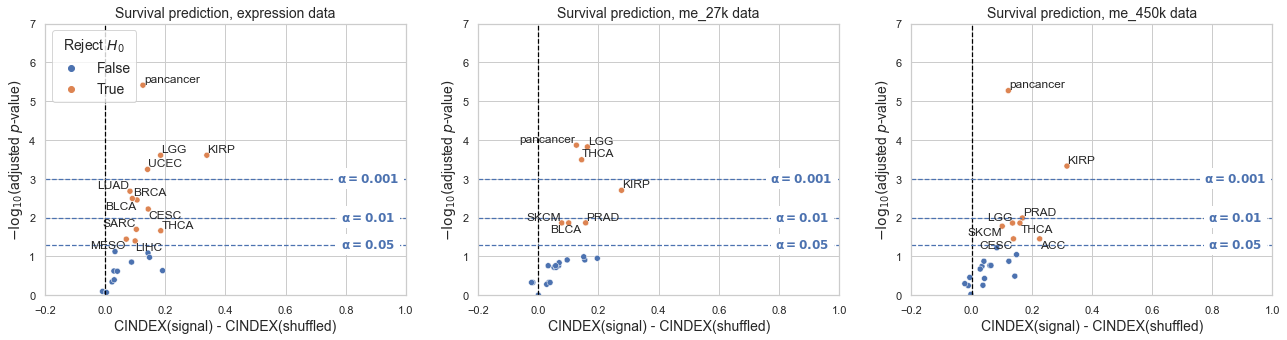

In [14]:
sns.set()
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# just use shortened data type names
training_data_map = {k: k for k in sorted(me_all_results_df.training_data.unique())}

plu.plot_volcano_baseline(me_all_results_df,
                          axarr,
                          training_data_map,
                          SIG_ALPHA,
                          identifier='cancer_type',
                          metric='cindex',
                          predict_str='Survival prediction',
                          verbose=True,
                          ylim=(0, 7))

if SAVE_FIGS:
    plt.savefig(images_dir / 'me_vs_shuffled_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'me_vs_shuffled_survival.png',
                dpi=300, bbox_inches='tight')

In [15]:
me_results_df = (me_results_df
    .drop(columns=['identifier'])
    .rename(columns={'cancer_type': 'identifier'})
).copy()

training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
}
me_results_df.training_data.replace(to_replace=training_data_map, inplace=True)
me_results_df.head()

,cindex,data_type,identifier,training_data,signal,seed,fold
0,0.85360,train,LIHC,450k methylation,shuffled,42,0
1,0.85360,cv,LIHC,450k methylation,shuffled,42,0
2,0.41490,test,LIHC,450k methylation,shuffled,42,0
3,0.77704,train,LIHC,450k methylation,shuffled,42,1
4,0.77704,cv,LIHC,450k methylation,shuffled,42,1


size 0 results array for KICH, skipping
shapes unequal for TGCT, skipping
shapes unequal for READ, skipping


27k methylation: 0/30


size 0 results array for KICH, skipping


450k methylation: 0/32


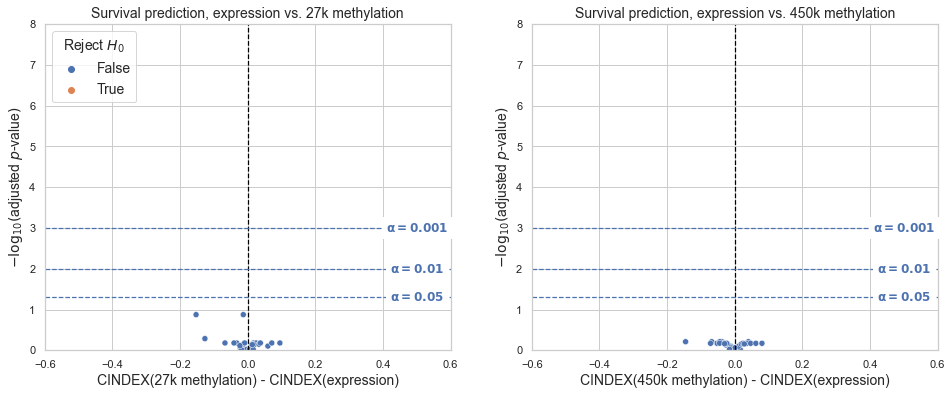

In [16]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (16, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

plu.plot_volcano_comparison(me_results_df,
                            axarr,
                            training_data_map,
                            SIG_ALPHA,
                            metric='cindex',
                            predict_str='Survival prediction',
                            xlim=(-0.6, 0.6),
                            verbose=True)

# if SAVE_FIGS:
#     plt.savefig(images_dir / 'methylation_comparison.svg', bbox_inches='tight')
#     plt.savefig(images_dir / 'methylation_comparison.png',
#                 dpi=300, bbox_inches='tight')

### Same plots, for all data types

In [17]:
# set results directory
all_results_dir = Path(cfg.repo_root,
                       '06_predict_survival',
                       'results_all_extended_alphas',
                       'results_1000_pca').resolve()
all_results_desc = 'top 1000 PCs'

# load results into a single dataframe
all_data_results_df = su.load_survival_results(all_results_dir)
all_data_results_df.rename(columns={'identifier': 'cancer_type',
                                    'fold_no': 'fold'}, inplace=True)
all_data_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.50000,train,LIHC,me_450k,shuffled,42,0
1,0.50000,cv,LIHC,me_450k,shuffled,42,0
2,0.50000,test,LIHC,me_450k,shuffled,42,0
3,0.80955,train,LIHC,me_450k,shuffled,42,1
4,0.80955,cv,LIHC,me_450k,shuffled,42,1


### Check model convergence results, all data types

In [18]:
all_data_count_df = (all_data_results_df[all_data_results_df.data_type == 'test']
    .groupby(['cancer_type', 'training_data'])
    .count()
)
problem_df = all_data_count_df[all_data_count_df['cindex'] != 16].copy()
print(len(problem_df), '/', len(all_data_count_df))
problem_df

16 / 162


cindex  data_type  signal  seed  fold
cancer_type training_data                                       
BLCA        mut_sigs           12         12      12    12    12
CESC        expression         12         12      12    12    12
            me_27k             12         12      12    12    12
            me_450k             8          8       8     8     8
            mirna              12         12      12    12    12
            mut_sigs           12         12      12    12    12
            rppa               12         12      12    12    12
ESCA        mirna              12         12      12    12    12
KIRP        me_27k             12         12      12    12    12
READ        expression         12         12      12    12    12
            me_27k              8          8       8     8     8
            me_450k            12         12      12    12    12
            mirna              12         12      12    12    12
            mut_sigs           12         12      12    12    12
            rppa               12         12      12    12    12
TGCT        me_450k            12         12      12    12    12

In [19]:
drop_cancer_types = problem_df.index.get_level_values(0).unique().values
print(drop_cancer_types)

['BLCA' 'CESC' 'ESCA' 'KIRP' 'READ' 'TGCT']


### Plot raw survival prediction results, all data types

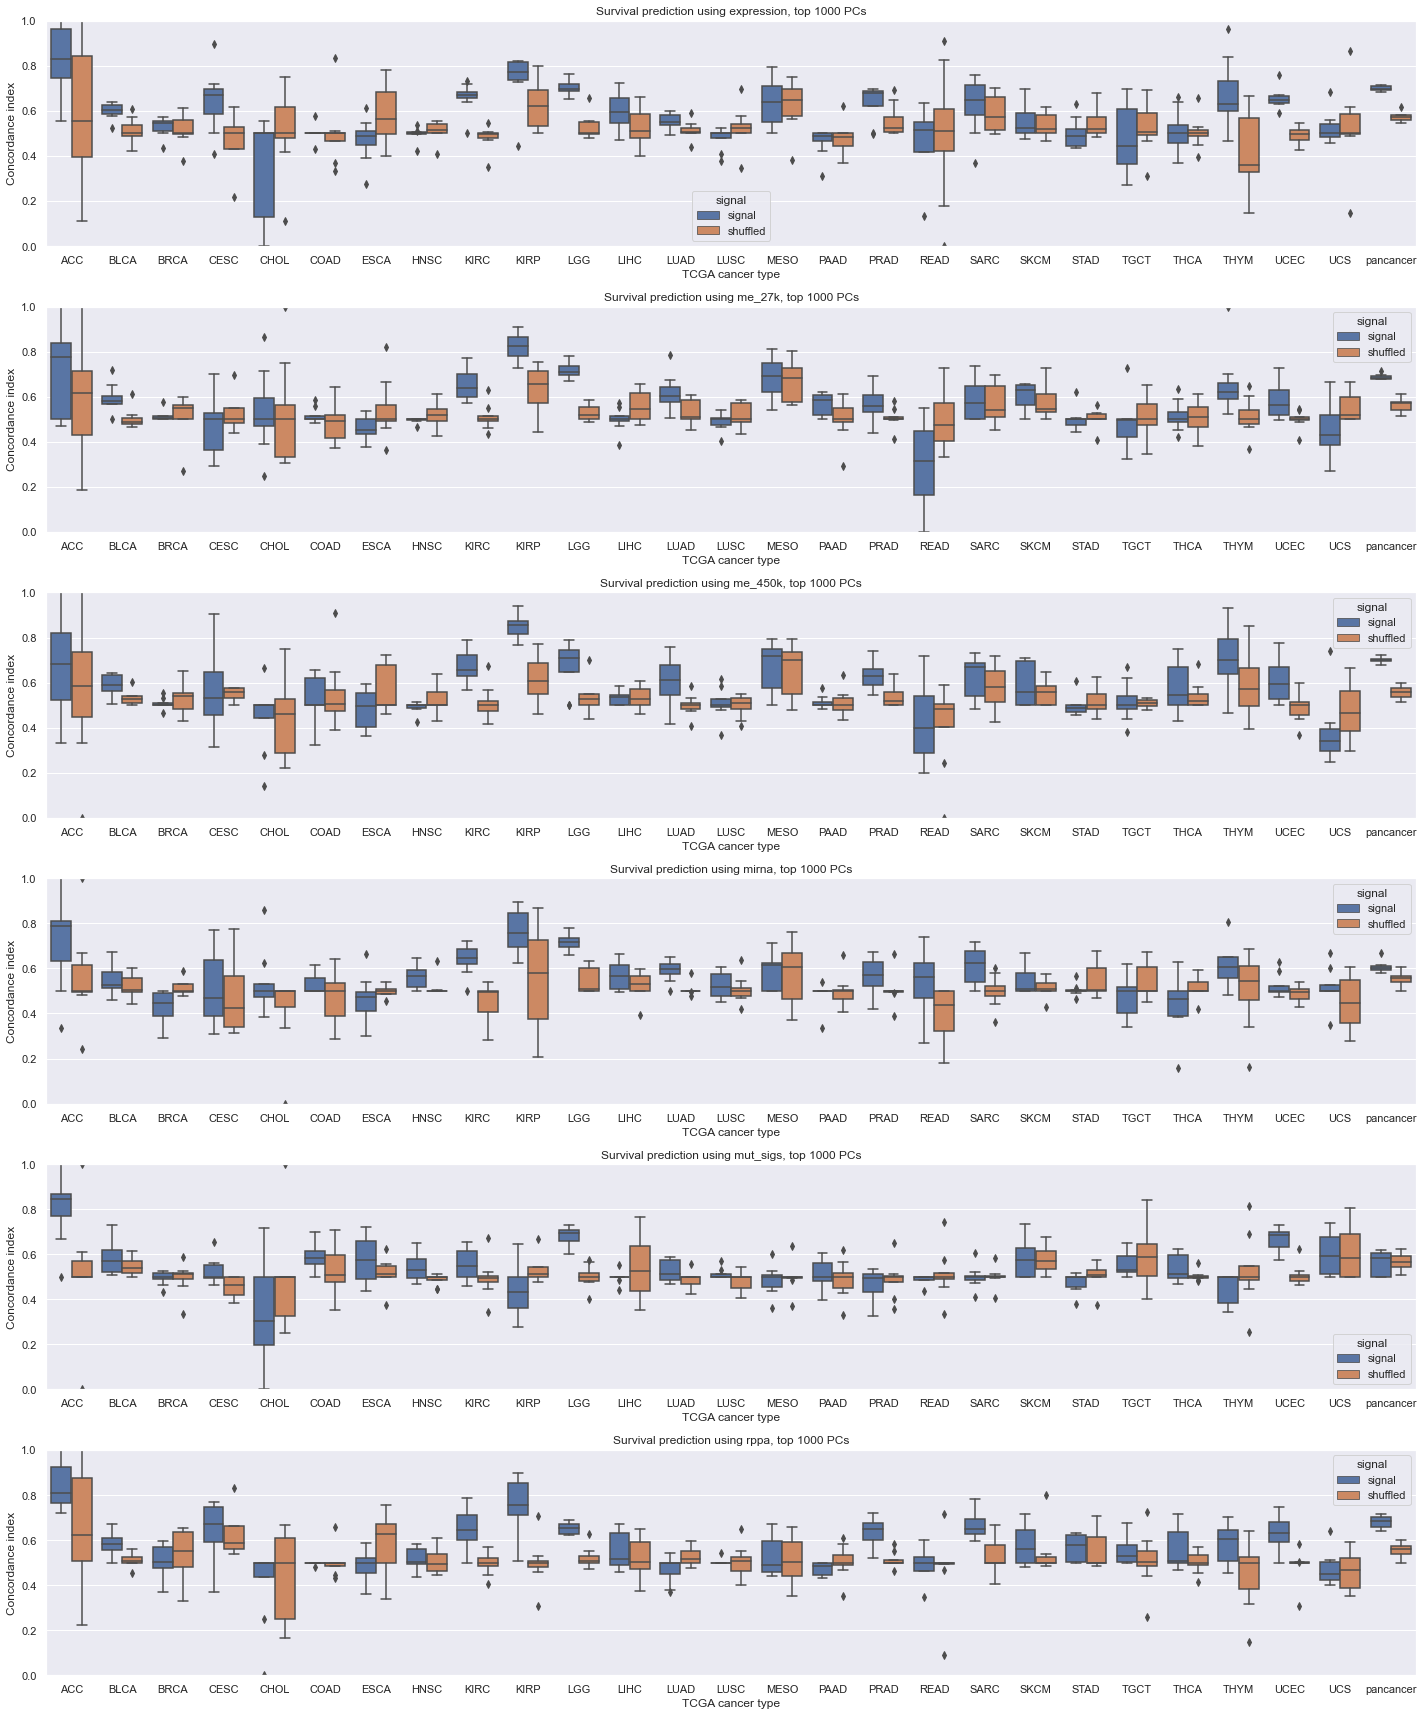

In [20]:
sns.set()
sns.set({'figure.figsize': (20, 24)})
fig, axarr = plt.subplots(6, 1)

for ix, data_type in enumerate(
    all_data_results_df.training_data.sort_values().unique()
):
    
    ax = axarr[ix]
    
    filtered_df = all_data_results_df[
        (all_data_results_df.training_data == data_type) &
        (all_data_results_df.data_type == 'test')
    ].copy()

    filtered_df.sort_values(by='cancer_type', inplace=True)

    sns.boxplot(data=filtered_df, x='cancer_type', y='cindex', hue='signal',
                hue_order=['signal', 'shuffled'], ax=ax)
    ax.set_xlabel('TCGA cancer type')
    ax.set_ylabel('Concordance index')
    ax.set_title('Survival prediction using {}, {}'.format(data_type,
                                                           all_results_desc))
    ax.set_ylim(0.0, 1.0)
    
plt.tight_layout()

In [21]:
all_data_results_df['identifier'] = (all_data_results_df.cancer_type + '_' +
                               all_data_results_df.training_data)
all_data_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold,identifier
0,0.50000,train,LIHC,me_450k,shuffled,42,0,LIHC_me_450k
1,0.50000,cv,LIHC,me_450k,shuffled,42,0,LIHC_me_450k
2,0.50000,test,LIHC,me_450k,shuffled,42,0,LIHC_me_450k
3,0.80955,train,LIHC,me_450k,shuffled,42,1,LIHC_me_450k
4,0.80955,cv,LIHC,me_450k,shuffled,42,1,LIHC_me_450k


In [22]:
all_data_compare_df = au.compare_control_ind(all_data_results_df,
                                       identifier='identifier',
                                       metric='cindex',
                                       verbose=True)
all_data_compare_df['cancer_type'] = all_data_compare_df.identifier.str.split('_', 1, expand=True)[0]
all_data_compare_df['training_data'] = all_data_compare_df.identifier.str.split('_', 1, expand=True)[1]

print(len(all_data_compare_df))
all_data_compare_df.head()

shapes unequal for BLCA_mut_sigs, skipping
shapes unequal for CESC_expression, skipping
shapes unequal for CESC_me_27k, skipping
shapes unequal for CESC_mirna, skipping
shapes unequal for CESC_mut_sigs, skipping
shapes unequal for CESC_rppa, skipping
shapes unequal for ESCA_mirna, skipping
shapes unequal for KIRP_me_27k, skipping
shapes unequal for READ_expression, skipping
shapes unequal for READ_me_450k, skipping
shapes unequal for READ_mirna, skipping
shapes unequal for READ_mut_sigs, skipping
shapes unequal for READ_rppa, skipping
shapes unequal for TGCT_me_450k, skipping


1176


,identifier,seed,fold,delta_cindex,cancer_type,training_data
0,ACC_expression,42,0,0.41904,ACC,expression
1,ACC_expression,42,1,0.37037,ACC,expression
2,ACC_expression,42,2,-0.31944,ACC,expression
3,ACC_expression,42,3,0.88889,ACC,expression
4,ACC_expression,1,0,0.37500,ACC,expression


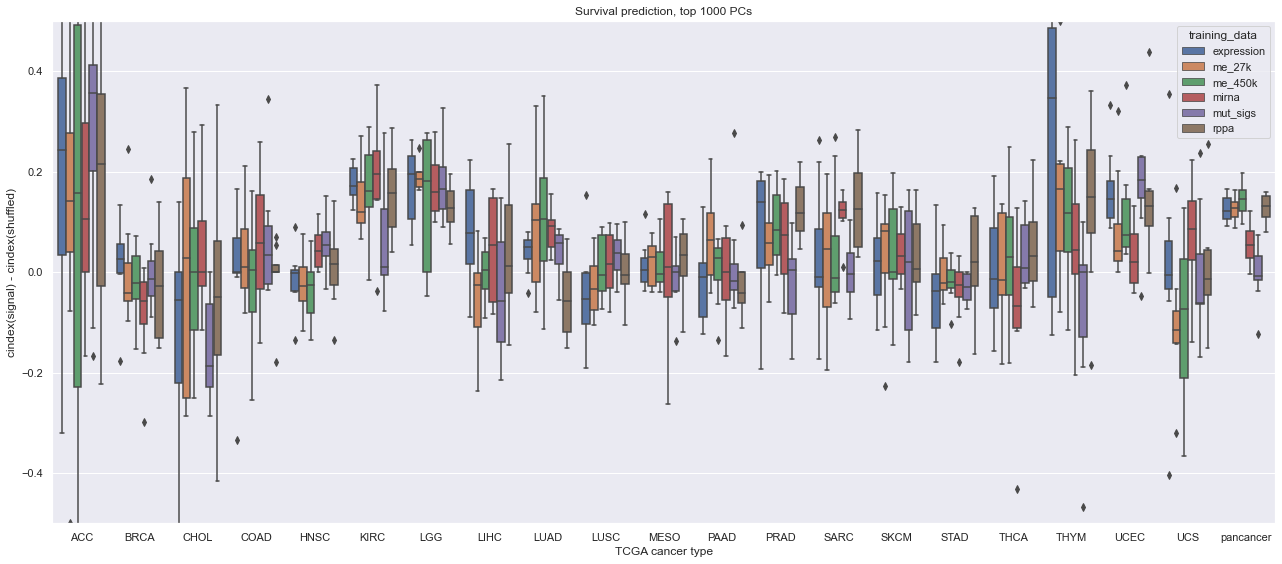

In [23]:
sns.set({'figure.figsize': (18, 8)})
    
all_data_compare_df.sort_values(by='cancer_type', inplace=True)

sns.boxplot(data=all_data_compare_df[~all_data_compare_df.cancer_type.isin(drop_cancer_types)],
            x='cancer_type',
            y='delta_cindex',
            hue='training_data',
            hue_order=sorted(all_data_compare_df.training_data.unique()))
plt.xlabel('TCGA cancer type')
plt.ylabel('cindex(signal) - cindex(shuffled)')
plt.title('Survival prediction, {}'.format(all_results_desc))
plt.ylim(-0.5, 0.5)
    
plt.tight_layout()

### Heatmap, all data types

In [24]:
all_data_all_results_df = au.compare_all_data_types(all_data_results_df[~all_data_results_df.cancer_type.isin(drop_cancer_types)],
                                                    SIG_ALPHA,
                                                    identifier='cancer_type',
                                                    metric='cindex')

all_data_all_results_df.rename(columns={'gene': 'cancer_type'}, inplace=True)
all_data_all_results_df.sort_values(by='p_value').head(10)

,cancer_type,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
6,LGG,0.189308,2.546756e-07,0.000005,True,me_27k,5.271793
20,pancancer,0.124341,2.201015e-06,0.000023,True,me_27k,4.636188
5,KIRC,0.177135,2.465518e-06,0.000029,True,expression,4.543900
20,pancancer,0.126032,2.722139e-06,0.000029,True,expression,4.543900
20,pancancer,0.127583,4.355788e-06,0.000091,True,rppa,4.038714
20,pancancer,0.144278,6.687170e-06,0.000140,True,me_450k,3.852538
6,LGG,0.130178,1.188075e-04,0.001247,True,rppa,2.903967
6,LGG,0.170550,1.209882e-04,0.002541,True,mirna,2.595038
13,SARC,0.114078,2.476011e-04,0.002600,True,mirna,2.585058
6,LGG,0.177242,2.969021e-04,0.006235,True,mut_sigs,2.205167


In [25]:
all_data_heatmap_df = (all_data_all_results_df
    .pivot(index='training_data', columns='cancer_type', values='delta_mean')
    .reindex(sorted(all_data_compare_df.training_data.unique()))
)
all_data_heatmap_df.iloc[:, :5]

cancer_type,ACC,BRCA,CHOL,COAD,HNSC
training_data,,,,,
expression,0.236959,0.015459,-0.153604,-0.004231,-0.013986
me_27k,0.114909,0.000937,0.006382,0.028516,-0.022586
me_450k,0.118164,-0.019215,0.004130,-0.023425,-0.037797
mirna,0.154185,-0.085250,0.120098,0.056387,0.045667
mut_sigs,0.281275,0.001444,-0.152300,0.065651,0.055802
rppa,0.176018,-0.031343,-0.039963,-0.006994,0.008130


In [26]:
raw_results_df = (all_data_results_df
    .drop(columns=['identifier'])
    .rename(columns={'cancer_type': 'identifier'})
)
raw_results_df.head()

,cindex,data_type,identifier,training_data,signal,seed,fold
0,0.50000,train,LIHC,me_450k,shuffled,42,0
1,0.50000,cv,LIHC,me_450k,shuffled,42,0
2,0.50000,test,LIHC,me_450k,shuffled,42,0
3,0.80955,train,LIHC,me_450k,shuffled,42,1
4,0.80955,cv,LIHC,me_450k,shuffled,42,1


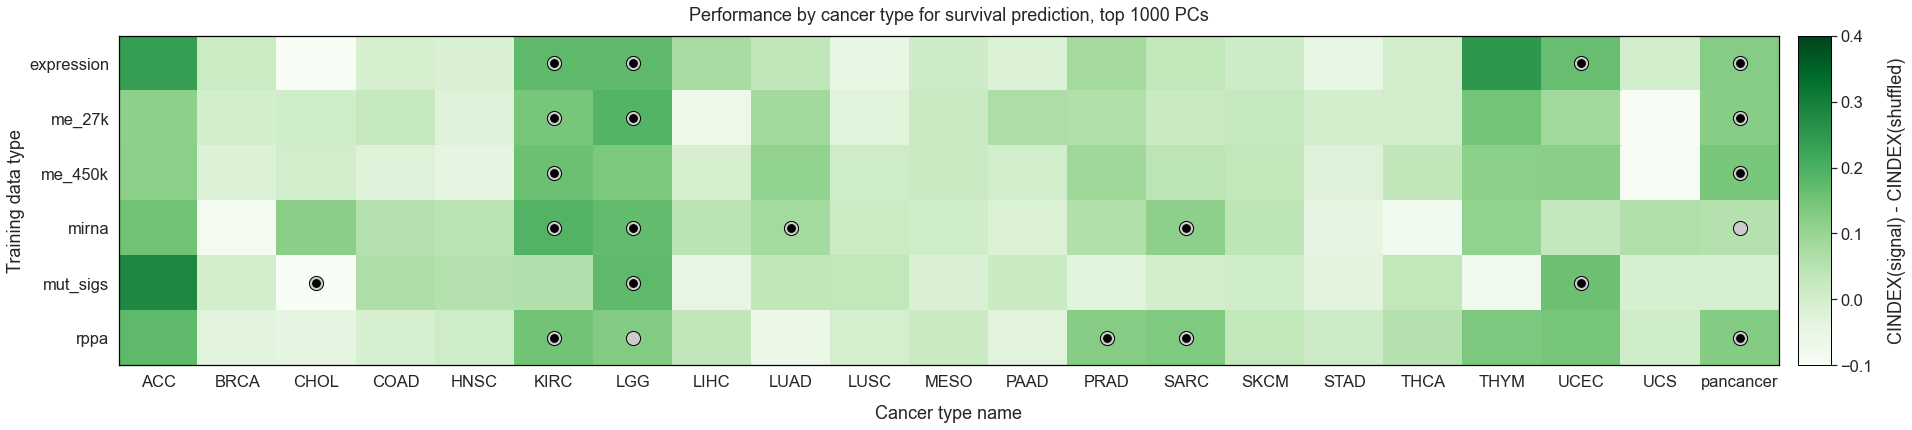

In [27]:
sns.set({'figure.figsize': (28, 6)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(all_data_heatmap_df,
                      all_data_all_results_df.reset_index(drop=True),
                      raw_results_df,
                      metric='cindex',
                      id_name='cancer_type',
                      scale=(-0.1, 0.4),
                      origin_eps_x=0.01,
                      origin_eps_y=0.01,
                      length_x=0.965,
                      length_y=0.95)

plt.title('Performance by cancer type for survival prediction, {}'.format(all_results_desc), pad=15)
if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'survival_all_heatmap.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'survival_all_heatmap.png',
                dpi=300, bbox_inches='tight')

Key to above heatmap:

* A grey dot = significantly better than label-permuted baseline, but significantly worse than best-performing data type
* A grey dot with black dot inside = significantly better than label-permuted baseline, and not significantly different from best-performing data type (i.e. "statistically equivalent to best")
* No dot = not significantly better than label-permuted baseline

expression: 4/21
me_27k: 3/21
me_450k: 2/21
mirna: 5/21
mut_sigs: 3/21
rppa: 5/21


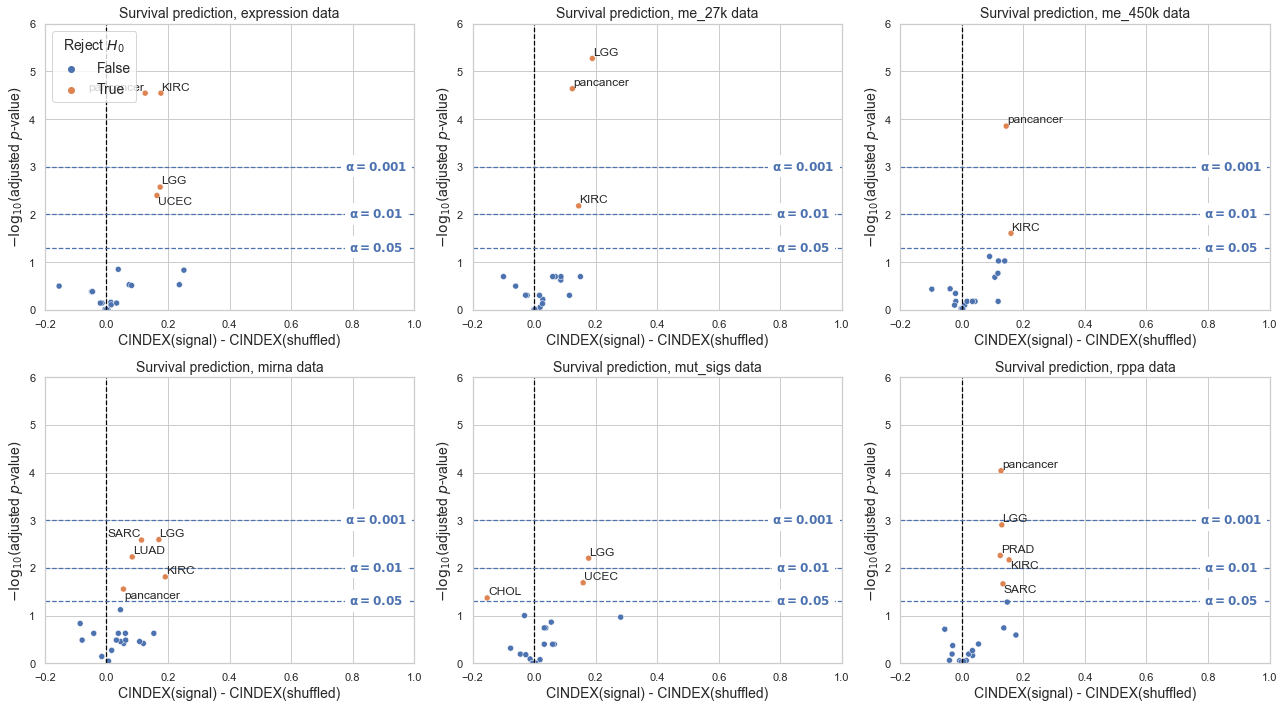

In [28]:
sns.set()
sns.set({'figure.figsize': (18, 10)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 3)

# just use shortened data type names
training_data_map = {k: k for k in sorted(all_data_all_results_df.training_data.unique())}

plu.plot_volcano_baseline(all_data_all_results_df,
                          axarr,
                          training_data_map,
                          SIG_ALPHA,
                          identifier='cancer_type',
                          metric='cindex',
                          predict_str='Survival prediction',
                          verbose=True,
                          ylim=(0, 6))

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_vs_shuffled_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_vs_shuffled_survival.png',
                dpi=300, bbox_inches='tight')

In [29]:
all_data_results_df = (all_data_results_df
    .drop(columns=['identifier'])
    .rename(columns={'cancer_type': 'identifier'})
).copy()

training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
all_data_results_df.training_data.replace(to_replace=training_data_map, inplace=True)
all_data_results_df.head()

,cindex,data_type,identifier,training_data,signal,seed,fold
0,0.50000,train,LIHC,450k methylation,shuffled,42,0
1,0.50000,cv,LIHC,450k methylation,shuffled,42,0
2,0.50000,test,LIHC,450k methylation,shuffled,42,0
3,0.80955,train,LIHC,450k methylation,shuffled,42,1
4,0.80955,cv,LIHC,450k methylation,shuffled,42,1


27k methylation: 1/27


shapes unequal for CESC, skipping


450k methylation: 0/26
RPPA: 0/27
microRNA: 3/27
mutational signatures: 4/27


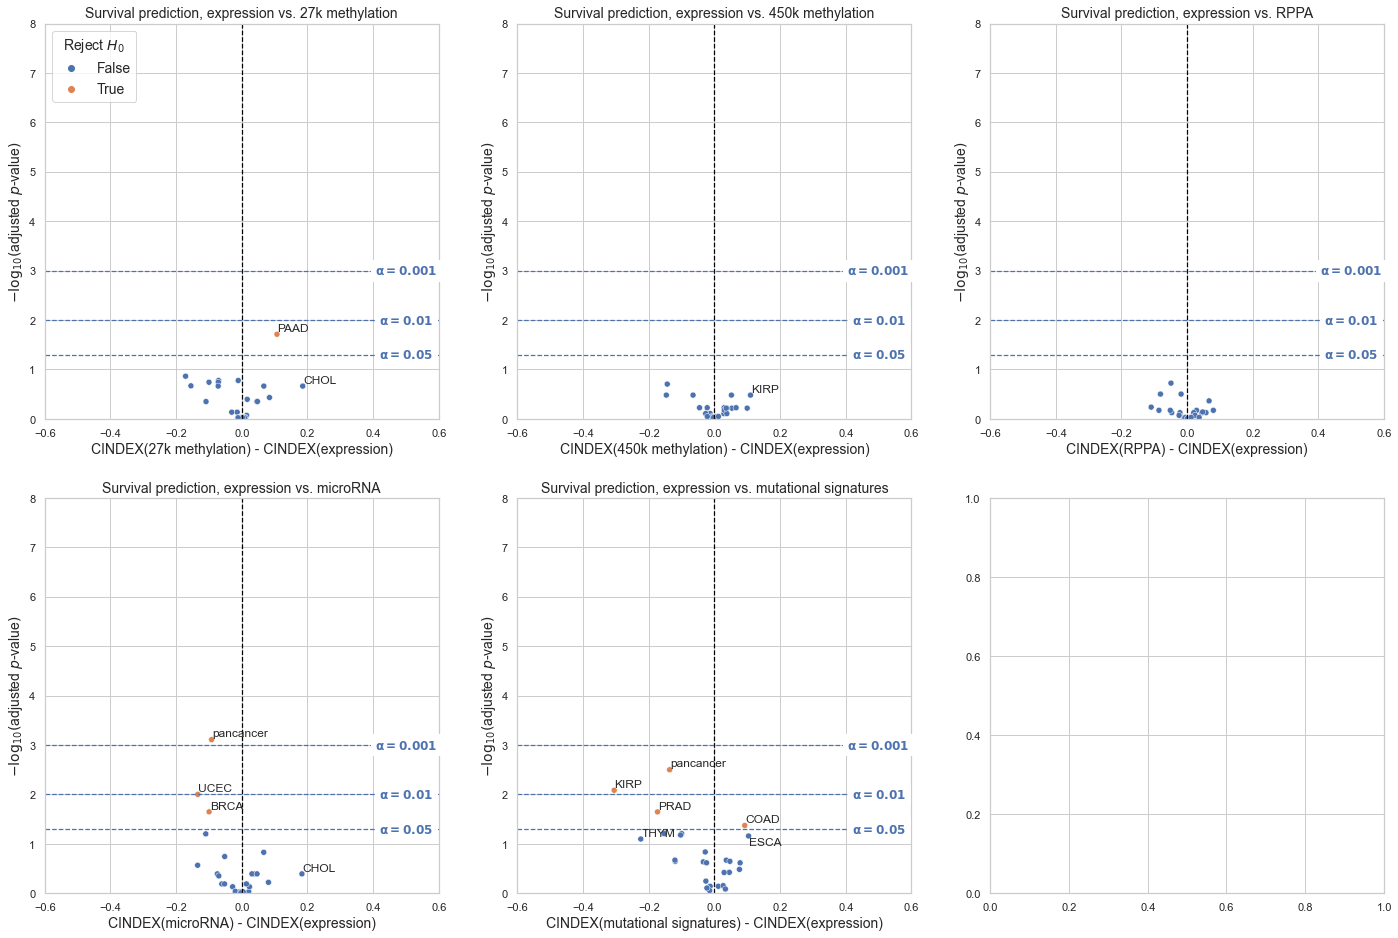

In [30]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (24, 16)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 3)

plu.plot_volcano_comparison(all_data_results_df,
                            axarr,
                            training_data_map,
                            SIG_ALPHA,
                            metric='cindex',
                            predict_str='Survival prediction',
                            xlim=(-0.6, 0.6),
                            verbose=True)

# if SAVE_FIGS:
#     plt.savefig(images_dir / 'methylation_comparison.svg', bbox_inches='tight')
#     plt.savefig(images_dir / 'methylation_comparison.png',
#                 dpi=300, bbox_inches='tight')